# Analyse des données publiées de l'UMR TETIS
Dans le cadre des journées d'UMR TETIS du 06 au 08 septembre 2022

In [1]:
import configparser
import requests
import pandas as pd
import numpy as np

In [2]:
# Lecture fichier contenant les clé API
credential_file = "./../credentials.ini"
credential_config = configparser.ConfigParser()
credential_config.read(credential_file)
print(credential_config.sections())


['DATA_INRAE', 'PREPROD_DATA_INRAE', 'CIRAD']


In [3]:
# Paramétrage API data.inrae.fr
API_TOKEN_data_inrae = credential_config['DATA_INRAE']['API_TOKEN']
url_rdg = "https://entrepot.recherche.data.gouv.fr/"
headers_data_inrae = {'Accept': 'application/json',
                     'X-Dataverse-key': API_TOKEN_data_inrae
}

In [4]:
# Paramétrage API https://dataverse.cirad.fr/
API_TOKEN_data_cirad = credential_config['CIRAD']['API_TOKEN']
url_cirad = "https://dataverse.cirad.fr/"
headers_data_cirad = {'Accept': 'application/json',
                     'X-Dataverse-key': API_TOKEN_data_cirad
}

In [5]:
# get the total size of a dataverse
def storage_szie_of_dataverse(dataverse, url=url_rdg, header=headers_data_inrae):
    url_dataverse = url + "api/dataverses/" + dataverse
    reponse = requests.get(url_dataverse + "/storagesize", headers=header).json()["data"]
    return reponse

# get dataset ID from a dataverse
def datasetID_from_dataverse(dataverse, url=url_rdg, header=headers_data_inrae):
    url_dataverse = url + "/api/dataverses/" + dataverse
    try:
        reponse = requests.get(url_dataverse + "/contents", headers=header).json()["data"]
    except:
        print(requests.get(url_dataverse + "/contents", headers=header).json())
        reponse = {}
    return reponse

# get all data from a dataverse
def datasets_info_from_datasetID(dataverse_content, url=url_rdg, header=headers_data_inrae):
    """
    """
    list_datasets = []
    list_dataverses = []
    for dataset in dataverse_content:
        try: 
            dataset_info = requests.get(url + "/api/datasets/" + str(dataset["id"]), headers=header).json()["data"]
            list_datasets.append(dataset_info)
        except: # it's not a dataset but a dataverse
            list_dataverses.append(str(dataset["title"]).replace(" ", "_"))
    return list_datasets, list_dataverses

# get view (total and uniques), download (unique & totla) and citation of a dataset
def get_metrics_of_datasets(doi):
    api_metrics = ["viewsTotal", "viewsUnique", "downloadsTotal", "downloadsUnique", "citations"]
    dic_api_metrics = {}
    for metric in api_metrics:
        url = url_rdg + "/api/datasets/:persistentId/makeDataCount/" + metric + "?persistentId=" + doi
        try: 
            reponse = requests.get(url, headers=headers_data_inrae).json()["data"][metric]
        except:
            reponse = 0
        dic_api_metrics[metric] = reponse
    print(dic_api_metrics)
    return dic_api_metrics

def get_metrics_of_datasets_cirad(doi):
    api_metrics = ["viewsTotal", "viewsUnique", "downloadsTotal", "downloadsUnique", "citations"]
    dic_api_metrics = {}
    for metric in api_metrics:
        url = url_cirad + "/api/datasets/:persistentId/makeDataCount/" + metric + "?persistentId=" + doi
        try: 
            reponse = requests.get(url, headers=headers_data_cirad).json()["data"][metric]
        except:
            reponse = 0
        dic_api_metrics[metric] = reponse
    return dic_api_metrics

## 1. Collect data and retrieve metrics
### 1.1 Data INRAE

In [6]:
# Size of TETIS storage
storage_szie_of_dataverse("tetis")

{'message': 'Total size of the files stored in this dataverse: 15,182,776,424 bytes'}

In [7]:
list_of_dataverse_to_explore = []
list_of_dataverse_to_explore.append("tetis")
list_datasets = []
# Jump into dataverses inside the dataverse of TETIS!
while list_of_dataverse_to_explore:
    for dataverse in list_of_dataverse_to_explore:
        print("Dataverse: " + dataverse)
        datasetIDs = datasetID_from_dataverse(dataverse)
        print("\t Number of objects: " + str(len(datasetIDs)))
        try:
            list_datasets_local, list_dataverses_local = datasets_info_from_datasetID(datasetIDs)
            list_datasets.extend(list_datasets_local)
            list_of_dataverse_to_explore.extend(list_dataverses_local)
            print("\t Number of datasets: " + str(len(list_datasets_local)))
            print("\t Number of dataverse: " + str(len(list_dataverses_local)))
        except:
            pass
        list_of_dataverse_to_explore.remove(dataverse)
df_datasets = pd.json_normalize(list_datasets, max_level=10)

Dataverse: tetis
	 Number of objects: 46
	 Number of datasets: 36
	 Number of dataverse: 10
Dataverse: Ciron
{'status': 'ERROR', 'message': 'User @rdecoupes is not permitted to perform requested action.'}
	 Number of objects: 0
	 Number of datasets: 0
	 Number of dataverse: 0
Dataverse: Projet_FederActeur
	 Number of objects: 1
	 Number of datasets: 1
	 Number of dataverse: 0
Dataverse: GloUrb_project:_Floodplain_urbanization_at_global_scale
{'status': 'ERROR', 'message': "Can't find dataverse with identifier='GloUrb_project:_Floodplain_urbanization_at_global_scale'"}
	 Number of objects: 0
	 Number of datasets: 0
	 Number of dataverse: 0
Dataverse: Test_Collection
{'status': 'ERROR', 'message': "Can't find dataverse with identifier='Test_Collection'"}
	 Number of objects: 0
	 Number of datasets: 0
	 Number of dataverse: 0
Dataverse: MaccMic
	 Number of objects: 2
	 Number of datasets: 2
	 Number of dataverse: 0
Dataverse: El_Bahdja_Boudoua_Dataverse
{'status': 'ERROR', 'message': "Can

In [8]:
df_datasets = df_datasets[df_datasets['latestVersion.datasetPersistentId'].notna()]
# Get title
df_datasets["title"] = df_datasets["latestVersion.metadataBlocks.citation.fields"].apply(lambda x: x[0]["value"])

# Get authors
# df_datasets["author_1"] = df_datasets["latestVersion.metadataBlocks.citation.fields"].apply(lambda x: x[1]["value"][0]["datasetContactEmail"]["value"])
for index, row in df_datasets.iterrows():
    row = row["latestVersion.metadataBlocks.citation.fields"]
    nb_of_authors = 0
    try:
        for author in row[2]["value"]:
            df_datasets.at[index, "author" + str(nb_of_authors)] = author["authorName"]["value"]
            nb_of_authors += 1
    except:
        for author in row[3]["value"]:
            df_datasets.at[index, "author" + str(nb_of_authors)] = author["authorName"]["value"]
            nb_of_authors += 1

In [9]:
# Retrieve metrics
df_datasets[['viewsTotal', 'viewsUnique', 'downloadsTotal', 'downloadsUnique', 'citations']] = \
df_datasets["latestVersion.datasetPersistentId"].apply(lambda x: pd.Series(get_metrics_of_datasets(x)))

{'viewsTotal': 469, 'viewsUnique': 238, 'downloadsTotal': 21, 'downloadsUnique': 9, 'citations': 0}
{'viewsTotal': 636, 'viewsUnique': 441, 'downloadsTotal': 0, 'downloadsUnique': 0, 'citations': 0}
{'viewsTotal': 640, 'viewsUnique': 282, 'downloadsTotal': 87, 'downloadsUnique': 22, 'citations': 0}
{'viewsTotal': 450, 'viewsUnique': 208, 'downloadsTotal': 10, 'downloadsUnique': 4, 'citations': 0}
{'viewsTotal': 293, 'viewsUnique': 159, 'downloadsTotal': 3, 'downloadsUnique': 2, 'citations': 0}
{'viewsTotal': 273, 'viewsUnique': 143, 'downloadsTotal': 3, 'downloadsUnique': 2, 'citations': 0}
{'viewsTotal': 441, 'viewsUnique': 188, 'downloadsTotal': 21, 'downloadsUnique': 16, 'citations': 0}
{'viewsTotal': 439, 'viewsUnique': 248, 'downloadsTotal': 7, 'downloadsUnique': 6, 'citations': 0}
{'viewsTotal': 276, 'viewsUnique': 110, 'downloadsTotal': 3, 'downloadsUnique': 2, 'citations': 0}
{'viewsTotal': 364, 'viewsUnique': 140, 'downloadsTotal': 19, 'downloadsUnique': 13, 'citations': 0}
{'

In [11]:
# save to csv file to debug
df_datasets.to_csv("./../external_data/data_inrae.csv")

In [12]:
df_datasets

id identifier                    persistentUrl protocol authority  \
0   121258     MVHCLQ  https://doi.org/10.15454/MVHCLQ      doi  10.15454   
1   121785     4TEO6H  https://doi.org/10.15454/4TEO6H      doi  10.15454   
2   121900     GR5EFS  https://doi.org/10.15454/GR5EFS      doi  10.15454   
3   121924     QCKBKF  https://doi.org/10.15454/QCKBKF      doi  10.15454   
4   128143     T6OBBY  https://doi.org/10.15454/T6OBBY      doi  10.15454   
5   128147     TBZNRO  https://doi.org/10.15454/TBZNRO      doi  10.15454   
6   128629     M9PWCW  https://doi.org/10.15454/M9PWCW      doi  10.15454   
7   129399     9MXCK0  https://doi.org/10.15454/9MXCK0      doi  10.15454   
8   129503     7YDQS0  https://doi.org/10.15454/7YDQS0      doi  10.15454   
9   142514     PI9ESN  https://doi.org/10.57745/PI9ESN      doi  10.57745   
10  142629     DBGRDI  https://doi.org/10.57745/DBGRDI      doi  10.57745   
11  142646     HTSB24  https://doi.org/10.57745/HTSB24      doi  10.57745   
12  142652     3KAK3W  https://doi.org/10.57745/3KAK3W      doi  10.57745   
13  146075     XUZXDA  https://doi.org/10.57745/XUZXDA      doi  10.57745   
14  147422     KG3THA  https://doi.org/10.57745/KG3THA      doi  10.57745   
15  147425     KFBJJM  https://doi.org/10.57745/KFBJJM      doi  10.57745   
16  147429     MJTEUN  https://doi.org/10.57745/MJTEUN      doi  10.57745   
17  147431     GNNJAL  https://doi.org/10.57745/GNNJAL      doi  10.57745   
18  147436     MVUPA9  https://doi.org/10.57745/MVUPA9      doi  10.57745   
19  147451     7PMZHA  https://doi.org/10.57745/7PMZHA      doi  10.57745   
20  147455     0EGTOH  https://doi.org/10.57745/0EGTOH      doi  10.57745   
21  147462     015DKZ  https://doi.org/10.57745/015DKZ      doi  10.57745   
23  150058     1H2A3T  https://doi.org/10.57745/1H2A3T      doi  10.57745   
24  152475     YOFPOK  https://doi.org/10.57745/YOFPOK      doi  10.57745   
25  153173     EFQQ0F  https://doi.org/10.57745/EFQQ0F      doi  10.57745   
26  156493     Y3XROX  https://doi.org/10.57745/Y3XROX      doi  10.57745   
27  162875     XJDGP7  https://doi.org/10.57745/XJDGP7      doi  10.57745   
28  164613     6R81RT  https://doi.org/10.57745/6R81RT      doi  10.57745   
29  167675     A02XI3  https://doi.org/10.57745/A02XI3      doi  10.57745   
30  167836     45I5EL  https://doi.org/10.57745/45I5EL      doi  10.57745   
31  172917     99SNOZ  https://doi.org/10.57745/99SNOZ      doi  10.57745   
32  179411     2RUX6W  https://doi.org/10.57745/2RUX6W      doi  10.57745   
33  186141     C7QNTB  https://doi.org/10.57745/C7QNTB      doi  10.57745   
34  187763     G1LWND  https://doi.org/10.57745/G1LWND      doi  10.57745   
35  188330     7N1KMB  https://doi.org/10.57745/7N1KMB      doi  10.57745   
37  187798     F6TBHY  https://doi.org/10.57745/F6TBHY      doi  10.57745   
38  187803     IG5UL8  https://doi.org/10.57745/IG5UL8      doi  10.57745   
39  142633     OBEXYH  https://doi.org/10.57745/OBEXYH      doi  10.57745   
40  142655     ROWLJ7  https://doi.org/10.57745/ROWLJ7      doi  10.57745   
41  163090     EJ4CI3  https://doi.org/10.57745/EJ4CI3      doi  10.57745   

              publisher publicationDate                   storageIdentifier  \
0   Recherche Data Gouv      2021-10-20             inrae://10.15454/MVHCLQ   
1   Recherche Data Gouv      2021-10-15             inrae://10.15454/4TEO6H   
2   Recherche Data Gouv      2021-10-20             inrae://10.15454/GR5EFS   
3   Recherche Data Gouv      2021-10-21             inrae://10.15454/QCKBKF   
4   Recherche Data Gouv      2022-04-01             inrae://10.15454/T6OBBY   
5   Recherche Data Gouv      2022-04-01             inrae://10.15454/TBZNRO   
6   Recherche Data Gouv      2022-04-01             inrae://10.15454/M9PWCW   
7   Recherche Data Gouv      2022-04-01             inrae://10.15454/9MXCK0   
8   Recherche Data Gouv      2022-04-01             inrae://10.15454/7YDQS0   
9   Recherche Data Gouv      2022-05-18             inrae://

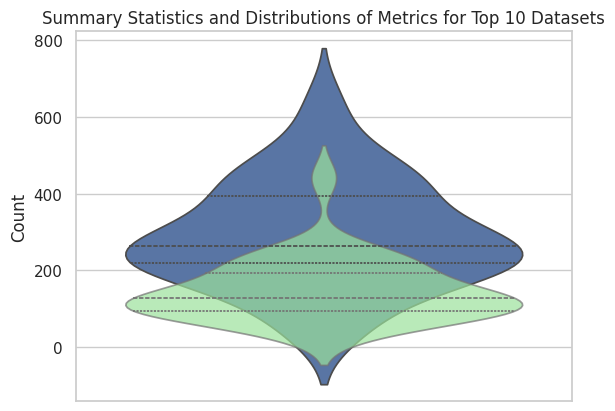

In [37]:
df_published = df_datasets[df_datasets["latestVersion.versionState"] == "RELEASED"]
stats = df_published.describe().T

summary_df = pd.DataFrame(stats[['count', 'mean', '50%', 'std']], columns=['Count', 'Mean', 'Median', 'Standard Deviation'])
summary_df['Quantile (25%)'] = stats['25%']
summary_df['Quantile (75%)'] = stats['75%']

# create a violin plot using seaborn to visualize the distributions of each metric
sns.violinplot(data=df_published, y="viewsTotal", inner="quart")
sns.violinplot(y=df_published['viewsUnique'], color='lightgreen', alpha=0.7, inner="quart")
# sns.violinplot(x=df_published.index, y=df_published['downloadsTotal'], color='pink', alpha=0.7)
# sns.violinplot(x=df_published.index, y=df_published['downloadsUnique'], color='lightcoral', alpha=0.7)

# add labels and title to the plot
plt.ylabel('Count')
plt.title('Summary Statistics and Distributions of Metrics for Top 10 Datasets')
plt.xticks(rotation=90)

# display the plot
plt.show()

In [28]:
stats

count           mean           std  \
id                                 28.0  149905.464286  21376.749293   
latestVersion.id                   28.0  266473.321429   2639.934133   
latestVersion.datasetId            28.0  149905.464286  21376.749293   
latestVersion.versionNumber        28.0       1.142857      0.448395   
latestVersion.versionMinorNumber   28.0       0.821429      1.743848   
viewsTotal                         28.0     291.928571    139.288650   
viewsUnique                        28.0     147.750000     82.495174   
downloadsTotal                     28.0       9.750000     13.077051   
downloadsUnique                    28.0       5.071429      6.127827   
citations                          28.0       0.000000      0.000000   

                                       min        25%       50%        75%  \
id                                121258.0  129477.00  147428.0  163470.75   
latestVersion.id                  263497.0  264664.00  264934.0  268297.50   
latestVersion.datasetId           121258.0  129477.00  147428.0  163470.75   
latestVersion.versionNumber            1.0       1.00       1.0       1.00   
latestVersion.versionMinorNumber       0.0       0.00       0.0       1.00   
viewsTotal                            46.0     217.75     262.5     392.50   
viewsUnique                           38.0      95.00     128.0     193.00   
downloadsTotal                         0.0       1.00       5.0      13.25   
downloadsUnique                        0.0       1.00       2.0       7.25   
citations                              0.0       0.00       0.0       0.00   

                                       max  
id                                187803.0  
latestVersion.id                  271930.0  
latestVersion.datasetId           187803.0  
latestVersion.versionNumber            3.0  
latestVersion.versionMinorNumber       8.0  
viewsTotal                           636.0  
viewsUnique                          441.0  
downloadsTotal                        55.0  
downloadsUnique                       25.0  
citations                              0.0

In [22]:
top_10 = df_datasets.sort_values('viewsTotal', ascending=False).head(10)[['title', 'viewsTotal', 'viewsUnique', 'downloadsTotal', 'downloadsUnique']]
print(top_10)

                                                title  viewsTotal  \
2   Labeled Entities from Social Media Data Relate...         640   
1                                     Package Fordead         636   
31  Annotated datasets from PADI-web for event-bas...         538   
10  Panoramas des paysages de Madagascar acquis pa...         518   
0   Données et produits lidar drone, réserve fores...         469   
3   Données lidar acquises par drone UE Citrus, Sa...         450   
6   Projet Artisols - Atlas cartographique - Occit...         441   
7   Projet Artisols - Indice de compacité des tach...         439   
26  Avian Influenza events from different digital ...         397   
21  Valorisation des données OCSGE Nouvelle Généra...         391   

    viewsUnique  downloadsTotal  downloadsUnique  
2           282              87               22  
1           441               0                0  
31          244              55               25  
10          460              12     

/tmp/ipykernel_4264/3111175835.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45, ha="right")


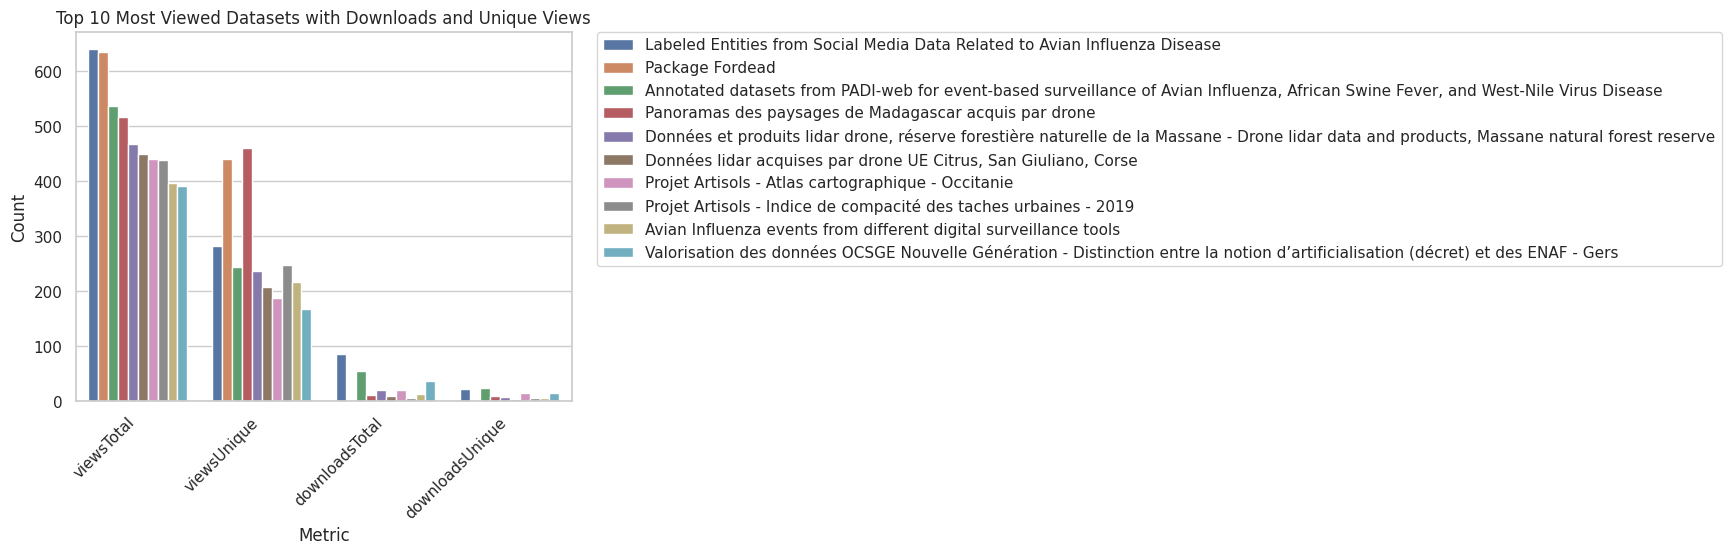

In [20]:
top_10 = df_datasets.sort_values('viewsTotal', ascending=False).head(10)[['title', 'viewsTotal', 'viewsUnique', 'downloadsTotal', 'downloadsUnique']]

# create a new DataFrame with the data in a tidy format for plotting
tidy_data = pd.melt(top_10, id_vars=['title'], value_vars=['viewsTotal', 'viewsUnique', 'downloadsTotal', 'downloadsUnique'])

# create a bar plot using seaborn
sns.set(style="whitegrid")
plot = sns.barplot(x='variable', y='value', hue='title', data=tidy_data)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, ha="right")
plot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# add labels and title to the plot
plot.set_ylabel("Count")
plot.set_xlabel("Metric")
plot.set_title("Top 10 Most Viewed Datasets with Downloads and Unique Views")

# display the plot
plt.show()

### 1.2 CIRAD : dataverseCIRAD

Le 2023-01-23, la version dataverse CIRAD était 5.13. [Voir doc dataverse 5.13](https://guides.dataverse.org/en/5.13/api/metrics.html)
Il est impossible de requêter au niveau du dataset.

De plus l'API makeDataCount n'était pas installée

In [ ]:
def nombre_datasets_cirad(dataverse):
    url = f"{url_cirad}/api/info/metrics/datasets/?parentAlias={dataverse}"
    try: 
        reponse = requests.get(url, headers=headers_data_cirad).json()["data"]["count"]
    except:
        reponse = np.nan
    return reponse

def time_series_upload_cirad(dataverse):
    url = f"{url_cirad}/api/info/metrics/datasets/monthly/?parentAlias={dataverse}"
    try: 
        reponse = requests.get(url, headers=headers_data_cirad).json()["data"]
    except:
        reponse = np.nan
    return reponse  

def time_series_download_cirad(dataverse):
    url = f"{url_cirad}/api/info/metrics/downloads/monthly/?parentAlias={dataverse}"
    try: 
        reponse = requests.get(url, headers=headers_data_cirad).json()["data"]
    except:
        reponse = np.nan
    return reponse  

In [ ]:
nombre_datasets_cirad("tetis")

121

In [ ]:
df_cirad_timeseries = pd.DataFrame(time_series_upload_cirad("tetis"))
df_cirad_timeseries.rename(columns={'count': 'upload_count'}, inplace=True)

df_cirad_timeseries_2 = pd.DataFrame(time_series_download_cirad("tetis"))
df_cirad_timeseries_2.rename(columns={'count': 'download_count'}, inplace=True)

df_cirad_timeseries = pd.merge(df_cirad_timeseries, df_cirad_timeseries_2, on='date', how='inner')

df_cirad_timeseries["ratio_dataset_download"] = df_cirad_timeseries["download_count"] / df_cirad_timeseries["upload_count"]



In [ ]:
df_cirad_timeseries

date  upload_count  download_count  ratio_dataset_download
0  2017-09-01            12               1                0.083333
1  2017-10-01            12               2                0.166667
2  2017-11-01            15               5                0.333333
3  2017-12-01            16              13                0.812500
4  2018-01-01            18              67                3.722222
..        ...           ...             ...                     ...
72 2023-09-01           113            5703               50.469027
73 2023-10-01           117            5892               50.358974
74 2023-11-01           119            6105               51.302521
75 2023-12-01           121            6294               52.016529
76 2024-01-01           121            6381               52.735537

[77 rows x 4 columns]

NameError: name 'df_cirad_timeseries' is not defined

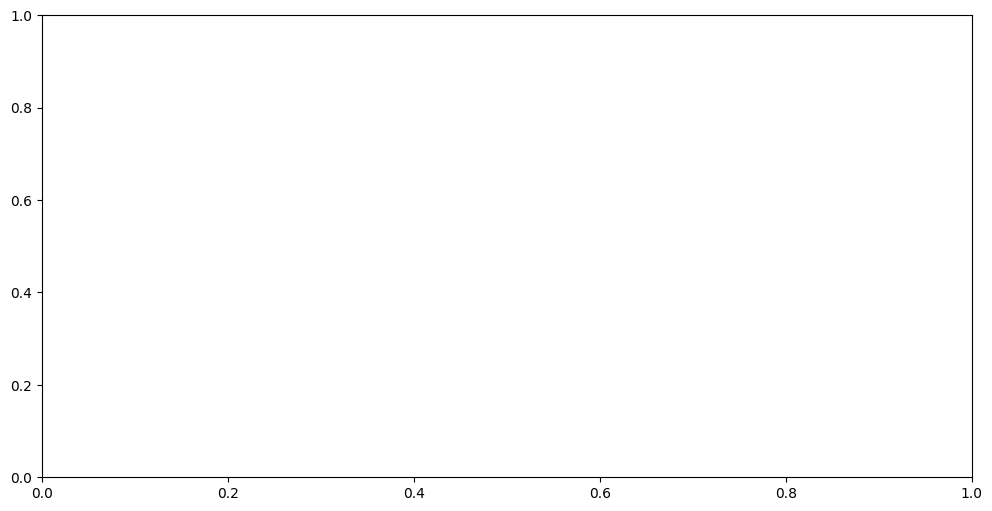

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


fig, ax1 = plt.subplots(figsize=(12, 6))

# Barplot pour upload_count sur le premier axe y
sns.barplot(x='date', y='upload_count', data=df_cirad_timeseries, color='skyblue', ax=ax1, label='Nb de jeux de données TETIS')

# Rotation des étiquettes de l'axe des x
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Ajouter une légende pour le premier axe y
ax1.legend(loc='upper left')

ax1.set_ylabel('Nb de datasets & Nb de téléchargement moyen par dataset')

# Créer le deuxième axe y
ax2 = ax1.twinx()

# Barplot pour download_count sur le deuxième axe y
sns.barplot(x='date', y='download_count', data=df_cirad_timeseries, color='lightcoral', ax=ax2, label='Nombre de téléchargement d\'un jeu de données TETIS', alpha=0.7)

# Ajouter une légende pour le deuxième axe y
ax2.legend(loc='upper right')

ax2.set_ylabel('Nb de téléchargement')

sns.lineplot(x='date', y='ratio_dataset_download', data=df_cirad_timeseries, color='green', label='Ratio de téléchargement', ax=ax1)

# Ajouter des étiquettes et un titre
plt.xlabel('Mois')
plt.title('Histogramme du Upload Count et Download Count par mois')
tick_positions = range(0, len(df_cirad_timeseries['date'].unique()), 4)
plt.xticks(tick_positions, df_cirad_timeseries['date'].unique()[tick_positions]);

In [ ]:
list_of_dataverse_to_explore = []
list_of_dataverse_to_explore.append("tetis")
list_datasets = []
# Jump into dataverses inside the dataverse of TETIS!
while list_of_dataverse_to_explore:
    for dataverse in list_of_dataverse_to_explore:
        print("Dataverse: " + dataverse)
        datasetIDs = datasetID_from_dataverse(dataverse, url=url_cirad, header=headers_data_cirad)
        print("\t Number of objects: " + str(len(datasetIDs)))
        try:
            list_datasets_local, list_dataverses_local = datasets_info_from_datasetID(datasetIDs, url=url_cirad, header=headers_data_cirad)
            list_datasets.extend(list_datasets_local)
            list_of_dataverse_to_explore.extend(list_dataverses_local)
            print("\t Number of datasets: " + str(len(list_datasets_local)))
            print("\t Number of dataverse: " + str(len(list_dataverses_local)))
        except:
            pass
        list_of_dataverse_to_explore.remove(dataverse)
df_datasets_cirad = pd.json_normalize(list_datasets, max_level=10)

In [ ]:
# Retrieve metrics
df_datasets_cirad[['viewsTotal', 'viewsUnique', 'downloadsTotal', 'downloadsUnique', 'citations']] = \
df_datasets_cirad["latestVersion.datasetPersistentId"].apply(lambda x: pd.Series(get_metrics_of_datasets_cirad(x)))

In [ ]:
# save to csv file to debug
df_datasets_cirad.to_csv("data_cirad.csv")
df_datasets_cirad

## 2. Playing with the API

In [ ]:
url_dataverse = url_rdg + "/api/dataverses/tetis"
reponse = requests.get(url_dataverse + "/facets", headers=headers_data_inrae).json()
reponse

In [ ]:
get_metrics_of_datasets("doi:10.15454/GR5EFS")

In [ ]:
url_dataverse = url_cirad + "api/dataverses/tetis"
print(url_dataverse + "/contents")
reponse = requests.get(url_dataverse + "/contents", headers=headers_data_cirad)
# reponse.json()
reponse.text

## 3. Figure, figure, figures !

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
plt.figure(figsize=(16, 10))
df_datasets["publicationDate"] = pd.to_datetime(df_datasets["publicationDate"])
# add vertical lines
plt.axvline(datetime.datetime(2022, 5, 24), label="Data Party 1", color="red", linewidth=4)
plt.text(datetime.datetime(2022, 5, 24), 20, ' Data Party 1', color="red")
plt.axvline(datetime.datetime(2023, 6, 8), label="Data Party 2", color="red", linewidth=4)
plt.text(datetime.datetime(2023, 6, 8), 20, ' Data Party 2', color="red")
plt.axvline(datetime.datetime(2022, 4, 1), label="Artisols", color="orange", linewidth=4)
plt.text(datetime.datetime(2022, 4, 1), 20, ' Artisols', color="orange")

sns.set_theme(style="whitegrid")
sns.histplot(data=df_datasets, x="publicationDate", cumulative=True, stat="count", binwidth=30, color="royalblue")
plt.savefig("image0001.png")


In [ ]:
plt.clf()


In [ ]:
df_datasets.keys()

In [ ]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]
top5_df_datasets = df_datasets.sort_values(by="viewsTotal", ascending=False).head(5)
plt.figure(figsize=(10, 6))
plt.pie(top5_df_datasets["viewsTotal"], labels=top5_df_datasets["title"])
plt.savefig("image0004.png", bbox_inches='tight')

In [ ]:
sns.set_theme(style="whitegrid")
top_df_datasets = df_datasets.sort_values(by="viewsTotal", ascending=False).head(7)
plt.figure(figsize=(15, 10))
sns.barplot(data=top_df_datasets, x="viewsTotal" , y="title")
plt.savefig("image0002.png", bbox_inches='tight')

In [ ]:
sns.set_theme(style="whitegrid")
top_df_datasets = df_datasets.sort_values(by="downloadsTotal", ascending=False).head(7)
plt.figure(figsize=(10, 10))
sns.barplot(data=top_df_datasets, x="downloadsTotal" , y="title")
plt.savefig("image0003.png", bbox_inches='tight')